In [1]:
!pip uninstall -y pandas pandas-datareader
!pip install "pandas<2.2.0" pandas-datareader

Found existing installation: pandas 2.1.4
Uninstalling pandas-2.1.4:
  Successfully uninstalled pandas-2.1.4
Found existing installation: pandas-datareader 0.10.0
Uninstalling pandas-datareader-0.10.0:
  Successfully uninstalled pandas-datareader-0.10.0
  Using cached pandas-2.1.4-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (18 kB)
  Using cached pandas_datareader-0.10.0-py3-none-any.whl.metadata (2.9 kB)
Using cached pandas-2.1.4-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (12.2 MB)
Using cached pandas_datareader-0.10.0-py3-none-any.whl (109 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2/2 [pandas-datareader]pandas-datareader]
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
fortitudo-tech 1.2.2 requires numpy>=2.0, but you have numpy 1.26.4 which is incompatible.


In [2]:
import sys
import pandas

# 1. Create a fake version of the missing/changed function
def fix_deprecate(old_arg_name, new_arg_name, stacklevel=2, condition=None):
    def wrapper(func):
        return func
    return wrapper

# 2. Inject it into the places datareader looks
import pandas.util._exceptions as _exc
_exc.deprecate_kwarg = fix_deprecate

# 3. Handle the 'is_list_like' move which often follows this error
from pandas.api.types import is_list_like
pandas.is_list_like = is_list_like

# 4. Now try the import
import pandas_datareader as pdr
print(f"Success! Using Pandas {pandas.__version__}")

Success! Using Pandas 2.1.4


In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import fortitudo.tech as ft
import yfinance as yf
import pandas_datareader as pdr
from cvxopt import matrix, solvers

solvers.options['show_progress'] = False

In [8]:
data = pd.read_parquet("merged_portfolio_data.parquet")
data['date'] = pd.to_datetime(data['date'])
data = data.set_index('date')


selected_assets = [
    'NVDA', 'LLY', 'GS', 'DECK', 'COST', 'CAT', 
    'BTU', 'SHW', 'NRG', 'NFLX', 'CBRE', 'GC=F'
]

benchmark_ticker = '^GSPC'

data = data[[t for t in selected_assets if t in data.columns]]
data_clean = data.dropna(axis=1, how='any')

start_date = data_clean.index[0]
end_date = data_clean.index[-1]

vix_raw = yf.download('^VIX', start=start_date, end=end_date, progress=False, auto_adjust=True)
vix = vix_raw['Close']['^VIX'] if isinstance(vix_raw.columns, pd.MultiIndex) else vix_raw['Close']

real_rate = pdr.DataReader('DFII10', 'fred', start_date, end_date)['DFII10']

inflation = pdr.DataReader('T10YIE', 'fred', start_date, end_date)['T10YIE']

state_vars = pd.DataFrame({
    'VIX': vix,
    'RealRate': real_rate,
    'Inflation': inflation
}).reindex(data_clean.index).ffill().dropna()

common_dates = data_clean.index.intersection(state_vars.index)
asset_data = data_clean.loc[common_dates]
state_vars = state_vars.loc[common_dates]

pnl = np.log(asset_data / asset_data.shift(1)).dropna()
state_vars = state_vars.loc[pnl.index]

print(f"Assets: {asset_data.shape[1]} | Days: {len(pnl)}")
print(f"Range: {pnl.index[0].date()} to {pnl.index[-1].date()}")
print(f"{len(pnl)/252:.1f} years of data\n")
print("State Variables:")
print(state_vars.describe().round(2))

Assets: 12 | Days: 2470
Range: 2016-01-05 to 2025-11-11
9.8 years of data

State Variables:
           VIX  RealRate  Inflation
count  2470.00   2470.00    2470.00
mean     18.52      0.63       2.05
std       7.38      1.00       0.38
min       9.14     -1.19       0.50
25%      13.48      0.06       1.76
50%      16.70      0.53       2.13
75%      21.54      1.57       2.33
max      82.69      2.52       3.02


In [9]:
vix = state_vars['VIX'].values
rr = state_vars['RealRate'].values
infl = state_vars['Inflation'].values

vix_25, vix_90 = np.percentile(vix, [25, 90])

vix_state = np.zeros(len(vix), dtype=int)
vix_state[vix <= vix_25] = 0                          
vix_state[(vix > vix_25) & (vix <= vix_90)] = 1       
vix_state[vix > vix_90] = 2                          

rr_50 = np.percentile(rr, 50)

rr_state = np.zeros(len(rr), dtype=int)
rr_state[rr <= rr_50] = 0   # Low
rr_state[rr > rr_50] = 1    # High

infl_50 = np.percentile(infl, 50)

infl_state = np.zeros(len(infl), dtype=int)
infl_state[infl <= infl_50] = 0   
infl_state[infl > infl_50] = 1    


states_vector = vix_state + 3 * rr_state + 6 * infl_state
n_states = 12

def decode_state(state_id):
    """Convert state_id (0-11) to human-readable regime."""
    vix_level = ['Low', 'Mid', 'High'][state_id % 3]
    rr_level = ['Low', 'High'][(state_id // 3) % 2]
    infl_level = ['Low', 'High'][state_id // 6]
    return f"VIX:{vix_level}|RR:{rr_level}|Infl:{infl_level}"

print("=" * 60)
print("REGIME CLASSIFICATION")
print("=" * 60)

print(f"\nThresholds:")
print(f"  VIX:       Low ≤ {vix_25:.1f} < Mid ≤ {vix_90:.1f} < High")
print(f"  RealRate:  Low ≤ {rr_50:.2f}% < High")
print(f"  Inflation: Low ≤ {infl_50:.2f}% < High")

print(f"\nState Distribution ({len(states_vector)} observations):")
state_counts = pd.Series(states_vector).value_counts().sort_index()

for state in range(n_states):
    count = (states_vector == state).sum()
    pct = 100 * count / len(states_vector)
    bar = '█' * int(pct / 2)
    print(f"  {state:2d} ({decode_state(state):25s}): {count:4d} ({pct:5.1f}%) {bar}")

print(f"\nSparsity check:")
print(f"  States with < 50 obs: {(state_counts < 50).sum()}")
print(f"  Min obs: {state_counts.min()} | Max obs: {state_counts.max()}")

current_state = states_vector[-1]
print(f"\n★ CURRENT REGIME: State {current_state} → {decode_state(current_state)}")

REGIME CLASSIFICATION

Thresholds:
  VIX:       Low ≤ 13.5 < Mid ≤ 27.5 < High
  RealRate:  Low ≤ 0.53% < High
  Inflation: Low ≤ 2.13% < High

State Distribution (2470 observations):
   0 (VIX:Low|RR:Low|Infl:Low  ):  354 ( 14.3%) ███████
   1 (VIX:Mid|RR:Low|Infl:Low  ):  397 ( 16.1%) ████████
   2 (VIX:High|RR:Low|Infl:Low ):  123 (  5.0%) ██
   3 (VIX:Low|RR:High|Infl:Low ):  129 (  5.2%) ██
   4 (VIX:Mid|RR:High|Infl:Low ):  239 (  9.7%) ████
   5 (VIX:High|RR:High|Infl:Low):   17 (  0.7%) 
   6 (VIX:Low|RR:Low|Infl:High ):    0 (  0.0%) 
   7 (VIX:Mid|RR:Low|Infl:High ):  313 ( 12.7%) ██████
   8 (VIX:High|RR:Low|Infl:High):   56 (  2.3%) █
   9 (VIX:Low|RR:High|Infl:High):  135 (  5.5%) ██
  10 (VIX:Mid|RR:High|Infl:High):  656 ( 26.6%) █████████████
  11 (VIX:High|RR:High|Infl:High):   51 (  2.1%) █

Sparsity check:
  States with < 50 obs: 1
  Min obs: 17 | Max obs: 656

★ CURRENT REGIME: State 10 → VIX:Mid|RR:High|Infl:High


In [10]:
T = len(pnl)
I = pnl.shape[1]
log_returns = pnl.values


half_life = T / 2
p_exp = ft.exp_decay_probs(log_returns, half_life=half_life)

print("=" * 60)
print("ENTROPY POOLING")
print("=" * 60)
print(f"\nExponential decay prior:")
print(f"  Half-life: {half_life:.0f} days ({half_life/252:.1f} years)")
print(f"  Oldest obs weight: {p_exp[0,0] / p_exp[-1,0]:.4f}x of newest")


mu_vix, sigma_vix = np.zeros(n_states), np.zeros(n_states)
mu_rr, sigma_rr = np.zeros(n_states), np.zeros(n_states)
mu_infl, sigma_infl = np.zeros(n_states), np.zeros(n_states)

MIN_OBS = 10  

print(f"\nRegime-specific moments (min {MIN_OBS} obs required):")
for state in range(n_states):
    mask = (states_vector == state)
    n_obs = mask.sum()
    
    if n_obs >= MIN_OBS:
        mu_vix[state], sigma_vix[state] = vix[mask].mean(), vix[mask].std()
        mu_rr[state], sigma_rr[state] = rr[mask].mean(), rr[mask].std()
        mu_infl[state], sigma_infl[state] = infl[mask].mean(), infl[mask].std()
        status = "✓"
    else:
        mu_vix[state], sigma_vix[state] = vix.mean(), vix.std()
        mu_rr[state], sigma_rr[state] = rr.mean(), rr.std()
        mu_infl[state], sigma_infl[state] = infl.mean(), infl.std()
        status = f"⚠ sparse ({n_obs} obs) → using unconditional"
    
    print(f"  State {state:2d}: VIX={mu_vix[state]:5.1f}±{sigma_vix[state]:4.1f}, "
          f"RR={mu_rr[state]:5.2f}±{sigma_rr[state]:4.2f}, "
          f"Infl={mu_infl[state]:4.2f}±{sigma_infl[state]:4.2f}  {status}")


A = np.vstack((
    np.ones((1, T)),
    vix[np.newaxis, :],
    rr[np.newaxis, :],
    infl[np.newaxis, :]
))

G = np.vstack((
    vix[np.newaxis, :] ** 2,
    rr[np.newaxis, :] ** 2,
    infl[np.newaxis, :] ** 2
))

q_states = []
ep_diagnostics = []

print(f"\nEntropy pooling optimization:")
for state in range(n_states):
    b = np.array([
        [1.0],
        [mu_vix[state]],
        [mu_rr[state]],
        [mu_infl[state]]
    ])
    
    h = np.array([
        [sigma_vix[state]**2 + mu_vix[state]**2],
        [sigma_rr[state]**2 + mu_rr[state]**2],
        [sigma_infl[state]**2 + mu_infl[state]**2]
    ])
    
    try:
        q = ft.entropy_pooling(p_exp, A, b, G, h)
        q = q / np.sum(q)  # Normalize
        
        ens = np.exp(-np.sum(q.flatten() * np.log(q.flatten() + 1e-12)))
        kl = np.sum(q.flatten() * np.log((q.flatten() + 1e-12) * T))
        
        q_states.append(q)
        ep_diagnostics.append({'state': state, 'ens': ens, 'kl': kl, 'success': True})
        print(f"  State {state:2d}: ✓ ENS={ens:6.0f}/{T} ({100*ens/T:4.1f}%), KL={kl:.3f}")
        
    except Exception as e:
        q_fallback = p_exp / np.sum(p_exp)
        q_states.append(q_fallback)
        ep_diagnostics.append({'state': state, 'ens': T, 'kl': 0, 'success': False})
        print(f"  State {state:2d}: ✗ EP failed, using prior. Error: {str(e)[:50]}")

states_prob = np.hstack(q_states)

print(f"\n✓ states_prob shape: {states_prob.shape} (T={T}, n_states={n_states})")
print(f"✓ Successful EP solutions: {sum(d['success'] for d in ep_diagnostics)}/{n_states}")

ENTROPY POOLING

Exponential decay prior:
  Half-life: 1235 days (4.9 years)
  Oldest obs weight: 0.2501x of newest

Regime-specific moments (min 10 obs required):
  State  0: VIX= 11.5± 1.2, RR= 0.34±0.16, Infl=1.79±0.17  ✓
  State  1: VIX= 18.5± 4.2, RR=-0.12±0.53, Infl=1.64±0.17  ✓
  State  2: VIX= 37.0±11.4, RR=-0.55±0.29, Infl=1.31±0.30  ✓
  State  3: VIX= 12.1± 1.0, RR= 0.69±0.12, Infl=2.00±0.12  ✓
  State  4: VIX= 18.6± 3.4, RR= 0.92±0.32, Infl=1.95±0.19  ✓
  State  5: VIX= 35.9±14.4, RR= 1.00±0.40, Infl=1.75±0.48  ✓
  State  6: VIX= 18.5± 7.4, RR= 0.63±1.00, Infl=2.05±0.38  ⚠ sparse (0 obs) → using unconditional
  State  7: VIX= 19.9± 3.0, RR=-0.69±0.44, Infl=2.46±0.18  ✓
  State  8: VIX= 30.3± 2.1, RR=-0.37±0.49, Infl=2.62±0.21  ✓
  State  9: VIX= 12.8± 0.5, RR= 1.78±0.41, Infl=2.25±0.06  ✓
  State 10: VIX= 18.1± 3.5, RR= 1.73±0.43, Infl=2.32±0.08  ✓
  State 11: VIX= 32.0± 4.8, RR= 1.54±0.51, Infl=2.36±0.15  ✓

Entropy pooling optimization:
  State  0: ✓ ENS=   426/2470 (17.3%

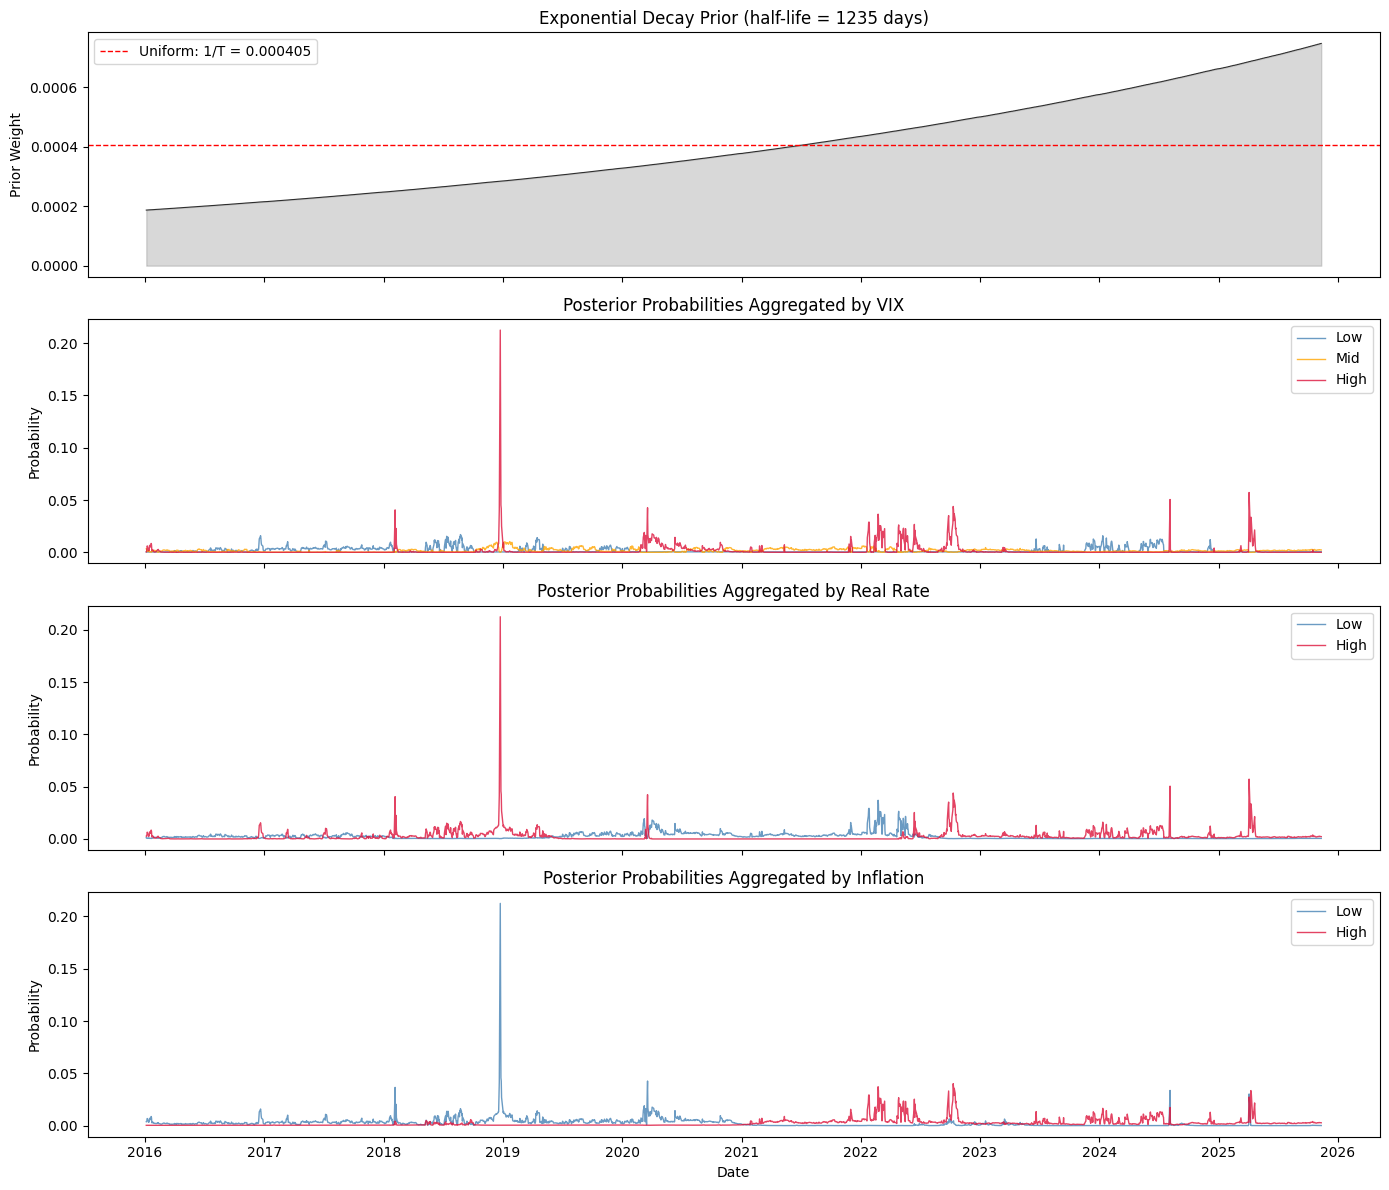

In [12]:
fig, axes = plt.subplots(4, 1, figsize=(14, 12), sharex=True)

dates = pnl.index
colors_vix = ['steelblue', 'orange', 'crimson']
colors_rr = ['steelblue', 'crimson']
colors_infl = ['steelblue', 'crimson']

ax = axes[0]
ax.plot(dates, p_exp.flatten(), 'k-', lw=0.8, alpha=0.8)
ax.fill_between(dates, 0, p_exp.flatten(), alpha=0.3, color='gray')
ax.set_ylabel('Prior Weight')
ax.set_title(f'Exponential Decay Prior (half-life = {half_life:.0f} days)')
ax.axhline(1/T, color='red', ls='--', lw=1, label=f'Uniform: 1/T = {1/T:.6f}')
ax.legend(loc='upper left')

ax = axes[1]
for vix_level in range(3):
    state_ids = [s for s in range(n_states) if s % 3 == vix_level]
    agg_prob = states_prob[:, state_ids].sum(axis=1)
    ax.plot(dates, agg_prob, color=colors_vix[vix_level], 
            label=['Low', 'Mid', 'High'][vix_level], lw=1, alpha=0.8)
ax.set_ylabel('Probability')
ax.set_title('Posterior Probabilities Aggregated by VIX')
ax.legend(loc='upper right')

ax = axes[2]
for rr_level in range(2):
    state_ids = [s for s in range(n_states) if (s // 3) % 2 == rr_level]
    agg_prob = states_prob[:, state_ids].sum(axis=1)
    ax.plot(dates, agg_prob, color=colors_rr[rr_level],
            label=['Low', 'High'][rr_level], lw=1, alpha=0.8)
ax.set_ylabel('Probability')
ax.set_title('Posterior Probabilities Aggregated by Real Rate')
ax.legend(loc='upper right')


ax = axes[3]
for infl_level in range(2):
    state_ids = [s for s in range(n_states) if s // 6 == infl_level]
    agg_prob = states_prob[:, state_ids].sum(axis=1)
    ax.plot(dates, agg_prob, color=colors_infl[infl_level],
            label=['Low', 'High'][infl_level], lw=1, alpha=0.8)
ax.set_ylabel('Probability')
ax.set_title('Posterior Probabilities Aggregated by Inflation')
ax.legend(loc='upper right')

plt.xlabel('Date')
plt.tight_layout()
plt.show()

In [13]:
def resampling(S, H, initial_state, states_prob, states_vector):
    """
    Generate S scenarios of H days using regime-aware Markov chain.
    
    Parameters:
    -----------
    S : int
        Number of Monte Carlo scenarios
    H : int
        Horizon in trading days
    initial_state : int
        Starting regime (0-11)
    states_prob : ndarray (T, n_states)
        Posterior probabilities from entropy pooling
    states_vector : ndarray (T,)
        Regime classification for each historical day
    
    Returns:
    --------
    sim_indices : ndarray (S, H)
        Sampled historical day indices for each scenario/day
    """
    T = len(states_vector)
    t_indices = np.arange(T)
    
    sim_indices = np.zeros((S, H), dtype=int)
    
    for s in range(S):
        current_state = initial_state
        for h in range(H):
            sim_indices[s, h] = np.random.choice(t_indices, p=states_prob[:, current_state])
            current_state = states_vector[sim_indices[s, h]]
    
    return sim_indices


S = 10000       
H = 63          

np.random.seed(42)  

print("=" * 60)
print("MARKOV CHAIN RESAMPLING")
print("=" * 60)

print(f"\nConfiguration:")
print(f"  Scenarios (S):     {S:,}")
print(f"  Horizon (H):       {H} days ({H/21:.1f} months)")
print(f"  Initial state:     {current_state} ({decode_state(current_state)})")

from time import time
t_start = time()

sim_indices = resampling(S, H, current_state, states_prob, states_vector)

elapsed = time() - t_start
print(f"\n✓ Generated {S:,} × {H} = {S*H:,} samples in {elapsed:.2f}s")


sampled_log_returns = log_returns[sim_indices]  
cumulative_log_return = np.sum(sampled_log_returns, axis=1)  
return_sim = np.exp(cumulative_log_return) - 1  

print(f"✓ Return simulation shape: {return_sim.shape}")

print(f"\nScenario statistics (H={H} day cumulative returns):")
print(f"  {'Asset':<8} {'Mean':>8} {'Std':>8} {'5th%':>8} {'95th%':>8}")
print(f"  {'-'*8} {'-'*8} {'-'*8} {'-'*8} {'-'*8}")

for i, asset in enumerate(pnl.columns):
    mean_ret = return_sim[:, i].mean() * 100
    std_ret = return_sim[:, i].std() * 100
    p5 = np.percentile(return_sim[:, i], 5) * 100
    p95 = np.percentile(return_sim[:, i], 95) * 100
    print(f"  {asset:<8} {mean_ret:>7.2f}% {std_ret:>7.2f}% {p5:>7.2f}% {p95:>7.2f}%")

print(f"\nRegime transitions in simulations:")

final_states = states_vector[sim_indices[:, -1]]
final_state_counts = pd.Series(final_states).value_counts().sort_index()

print(f"  Starting state: {current_state} ({decode_state(current_state)})")
print(f"\n  Final state distribution after {H} days:")
for state in range(n_states):
    count = (final_states == state).sum()
    pct = 100 * count / S
    bar = '█' * int(pct / 2)
    if count > 0:
        print(f"    State {state:2d}: {pct:5.1f}% {bar}")

MARKOV CHAIN RESAMPLING

Configuration:
  Scenarios (S):     10,000
  Horizon (H):       63 days (3.0 months)
  Initial state:     10 (VIX:Mid|RR:High|Infl:High)

✓ Generated 10,000 × 63 = 630,000 samples in 27.73s
✓ Return simulation shape: (10000, 12)

Scenario statistics (H=63 day cumulative returns):
  Asset        Mean      Std     5th%    95th%
  -------- -------- -------- -------- --------
  NVDA       27.06%   31.87%  -20.81%   82.77%
  LLY        11.65%   15.27%  -12.36%   38.10%
  GS          9.44%   14.82%  -13.86%   33.81%
  DECK        7.37%   22.25%  -26.37%   46.07%
  COST        9.21%   12.10%  -10.56%   29.06%
  CAT        11.11%   16.13%  -14.62%   38.14%
  BTU        62.27%  533.97%  -37.77%  127.56%
  SHW         8.39%   13.49%  -13.52%   30.84%
  NRG         9.53%   20.90%  -21.09%   46.33%
  NFLX       14.21%   23.80%  -23.05%   53.85%
  CBRE       10.53%   16.78%  -16.51%   37.43%
  GC=F        4.85%    7.91%   -7.59%   18.14%

Regime transitions in simulations:


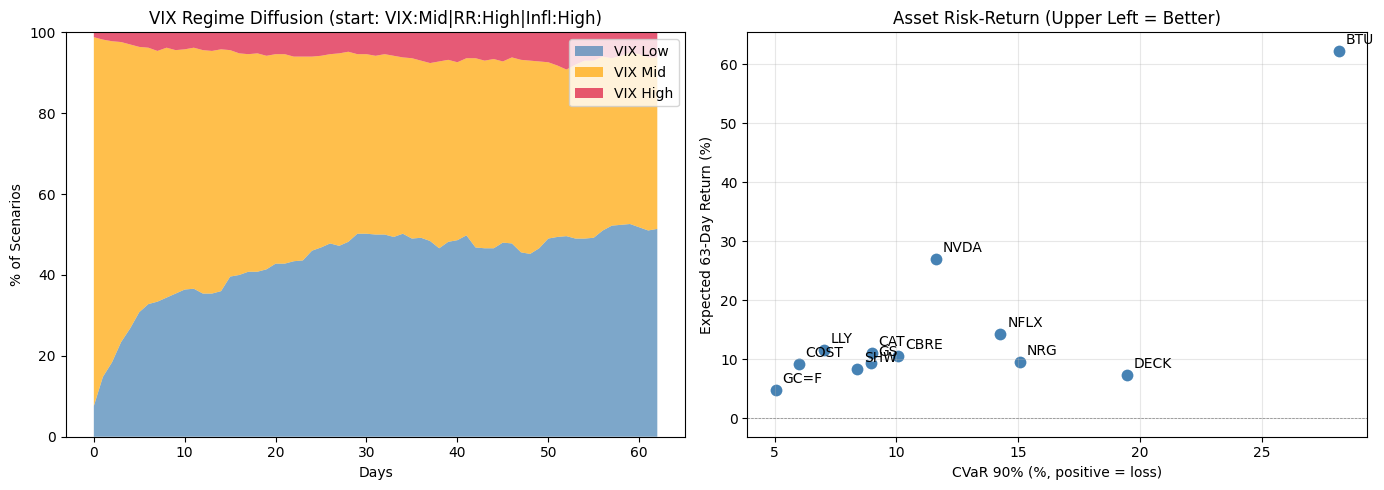

In [16]:
fig, axes = plt.subplots(1, 2,figsize=(14, 5))

ax = axes[0]

regime_paths = states_vector[sim_indices[:500, :]]  

vix_low_pct = np.mean(regime_paths % 3 == 0, axis=0) * 100
vix_mid_pct = np.mean(regime_paths % 3 == 1, axis=0) * 100
vix_high_pct = np.mean(regime_paths % 3 == 2, axis=0) * 100

ax.stackplot(range(H), vix_low_pct, vix_mid_pct, vix_high_pct,
             labels=['VIX Low', 'VIX Mid', 'VIX High'],
             colors=['steelblue', 'orange', 'crimson'], alpha=0.7)
ax.set_xlabel('Days')
ax.set_ylabel('% of Scenarios')
ax.set_title(f'VIX Regime Diffusion (start: {decode_state(current_state)})')
ax.legend(loc='upper right')
ax.set_ylim(0, 100)

ax = axes[1]

alpha = 0.90
asset_means = return_sim.mean(axis=0) * 100
asset_cvars = np.array([np.percentile(return_sim[:, i], (1-alpha)*100) 
                        for i in range(I)]) * 100

ax.scatter(-asset_cvars, asset_means, s=100, c='steelblue', edgecolors='white', lw=1.5)
for i, name in enumerate(pnl.columns):
    ax.annotate(name, (-asset_cvars[i], asset_means[i]), fontsize=10,
                xytext=(5, 5), textcoords='offset points')

ax.set_xlabel(f'CVaR {alpha:.0%} (%, positive = loss)')
ax.set_ylabel(f'Expected {H}-Day Return (%)')
ax.set_title('Asset Risk-Return (Upper Left = Better)')
ax.axhline(0, color='gray', ls='--', lw=0.5)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [18]:
print("=" * 60)
print("MEAN-CVaR OPTIMIZATION (fortitudo.tech)")
print("=" * 60)

alpha = 0.90
max_weight = 0.25

print(f"  Alpha: {alpha:.0%}")
print(f"  Assets: {I} | Scenarios: {S}")
print(f"  Constraints: LONG-SHORT, |w_i| <= {max_weight:.0%}")


G = np.vstack((np.eye(I), -np.eye(I)))
h = np.hstack((np.ones(I) * max_weight, np.ones(I) * max_weight))

print(f"  G shape: {G.shape}, h shape: {h.shape}")

cvar_opt = ft.MeanCVaR(return_sim, G, h, alpha=alpha)

print(f"\n✓ MeanCVaR optimizer initialized (sum(w)=1, net long)")

MEAN-CVaR OPTIMIZATION (fortitudo.tech)
  Alpha: 90%
  Assets: 12 | Scenarios: 10000
  Constraints: LONG-SHORT, |w_i| <= 25%
  G shape: (24, 12), h shape: (24,)

✓ MeanCVaR optimizer initialized (sum(w)=1, net long)


In [19]:
w_min_cvar = cvar_opt.efficient_portfolio()
min_cvar_return = (return_sim @ w_min_cvar).mean()

min_return = min_cvar_return
max_return = return_sim.mean(axis=0).max() * 0.9  # Don't push to infeasible

n_points = 15
target_returns = np.linspace(min_return, max_return, n_points)

frontier = []
print(f"\nTracing efficient frontier ({n_points} points)...")
print(f"  Return range: [{min_return*100:.2f}%, {max_return*100:.2f}%]")

for i, target in enumerate(target_returns):
    try:
        weights = cvar_opt.efficient_portfolio(target)
        port_return = (return_sim @ weights).mean()
        port_cvar = np.percentile(return_sim @ weights, (1 - alpha) * 100)
        
        long_exposure = weights[weights > 0].sum()
        short_exposure = weights[weights < 0].sum()
        
        frontier.append({
            'target': target,
            'return': port_return,
            'cvar': port_cvar,
            'weights': weights.copy(),
            'long': long_exposure,
            'short': short_exposure,
            'success': True
        })
        print(f"  {i+1:2d}: ret={port_return*100:>6.2f}%, CVaR={port_cvar*100:>7.2f}%, "
              f"L={long_exposure*100:>5.1f}%, S={short_exposure*100:>6.1f}%")
        
    except Exception as e:
        frontier.append({'target': target, 'success': False})
        print(f"  {i+1:2d}: target={target*100:>6.2f}% → FAILED")

print(f"\n✓ Successful: {sum(f['success'] for f in frontier)}/{n_points}")


Tracing efficient frontier (15 points)...
  Return range: [7.12%, 56.04%]
   1: ret=  7.12%, CVaR=  -1.95%, L=113.6%, S= -13.6%
   2: ret= 10.62%, CVaR=   0.02%, L=104.5%, S=  -4.5%
   3: ret= 14.11%, CVaR=  -0.02%, L=104.7%, S=  -4.7%
   4: ret= 17.60%, CVaR=  -0.43%, L=107.0%, S=  -7.0%
   5: ret= 21.10%, CVaR=  -1.14%, L=111.0%, S= -11.0%
   6: ret= 24.59%, CVaR=  -2.06%, L=118.5%, S= -18.5%
   7: ret= 28.09%, CVaR=  -2.96%, L=129.0%, S= -29.0%
   8: target= 31.58% → FAILED
   9: target= 35.08% → FAILED
  10: target= 38.57% → FAILED
  11: target= 42.07% → FAILED
  12: target= 45.56% → FAILED
  13: target= 49.05% → FAILED
  14: target= 52.55% → FAILED
  15: target= 56.04% → FAILED

✓ Successful: 7/15


In [21]:
# =============================================================================
# OPTIMAL PORTFOLIO (MAX EFFICIENCY) — FIXED
# =============================================================================

valid_frontier = [f for f in frontier if f['success'] and f['cvar'] < 0]

efficiencies = [f['return'] / (-f['cvar']) for f in valid_frontier]
best_idx = np.argmax(efficiencies)
optimal = valid_frontier[best_idx]

print("=" * 60)
print("OPTIMAL PORTFOLIO")
print("=" * 60)
print(f"  Expected {H}-day Return: {optimal['return']*100:>7.2f}%")
print(f"  CVaR ({alpha:.0%}):            {optimal['cvar']*100:>7.2f}%")
print(f"  Efficiency (Ret/|CVaR|):  {optimal['return']/(-optimal['cvar']):>7.3f}")
print(f"  Long / Short:             {optimal['long']*100:>5.1f}% / {optimal['short']*100:>5.1f}%")

# Extract weights as flat numpy array
weights_arr = np.array(optimal['weights']).flatten()

print(f"\n  LONG positions:")
for i, name in enumerate(pnl.columns):
    w = float(weights_arr[i])  # Convert to Python float
    if w > 0.01:
        bar = '█' * int(w * 40)
        print(f"    {name:<8} {w*100:>+6.1f}% {bar}")

print(f"\n  SHORT positions:")
for i, name in enumerate(pnl.columns):
    w = float(weights_arr[i])
    if w < -0.01:
        bar = '░' * int(-w * 40)
        print(f"    {name:<8} {w*100:>+6.1f}% {bar}")

optimal_weights = weights_arr

OPTIMAL PORTFOLIO
  Expected 63-day Return:   14.11%
  CVaR (90%):              -0.02%
  Efficiency (Ret/|CVaR|):  768.009
  Long / Short:             104.7% /  -4.7%

  LONG positions:
    NVDA       +8.6% ███
    LLY       +25.0% ██████████
    GS         +1.4% 
    COST      +17.4% ██████
    CAT        +2.8% █
    BTU        +6.9% ██
    SHW       +12.7% █████
    NRG        +1.7% 
    NFLX       +3.2% █
    GC=F      +25.0% ██████████

  SHORT positions:
    DECK       -3.7% ░
